In [2]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import vmap, lax 
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.special import gamma
from jax.scipy.linalg import cholesky
from typing import NamedTuple

In [3]:
class HyperParams(NamedTuple):
    N: int = 100 # number of odorants 
    n: int = 2 # sparsity of odor vectors--only applies for a Qin et al 2019 odor model 
    M: int = 30 # number of odorant receptors
    Q: int = 300 # number of olfactory receptor neurons 
    P: int = 1000 # number of samples when we compute MI

    sigma_0: jnp.float32 = jnp.array(0.01, dtype=jnp.float32) # neural noise in naive Gaussian model 
    sigma_c: jnp.float32 = jnp.array(2.0, dtype=jnp.float32) # std_dev of log normal Qin et al 2019 odorant model 

    nonlinearity: callable = lambda x: x / (1 + x) 

class Params(NamedTuple): 
    W: jnp.ndarray
    K: jnp.ndarray

In [4]:
def init(rng, scale=1, hp=None) -> Params: 
    if hp is None: 
        hp = HyperParams() 
    W_key, K_key = jax.random.split(rng) 
    W = scale * jax.random.gamma(W_key, a=1, shape=(hp.M, hp.N))
    K = scale * jax.random.gamma(K_key, a=1, shape=(hp.Q, hp.M))
    return hp, Params(W, K)

In [31]:
def draw_c_sparse_log_normal(subkey, hp): 
    c = jnp.zeros(hp.N)
    sub1, sub2 = jax.random.split(subkey) 
    non_zero_indices = jax.random.choice(sub1, hp.N, shape=(hp.n,), replace=False)
    concentrations = jax.random.lognormal(sub2, sigma=hp.sigma_c, shape=(hp.n,))
    c = c.at[non_zero_indices].set(concentrations)
    return c

def draw_cs_sparse_log_normal(subkey, hp): 
    keybatch = jax.random.split(subkey, hp.P)
    cs = vmap(draw_c_sparse_log_normal, in_axes=(0, None))(keybatch, hp).T 
    return cs 

def compute_activity(subkey, hp, p, c): 
    pre_activations = p.W @ c
    r = hp.nonlinearity(pre_activations) + hp.sigma_0 * jax.random.normal(subkey, shape=pre_activations.shape) 
    return r

def compute_entropy(r, hp):
    entropy = compute_sum_of_marginal_entropies(r, hp) - compute_information(r)
    return entropy

def compute_sum_of_marginal_entropies(r, hp, window=None):
    compute_entropy_vmap = vmap(vasicek_entropy, in_axes=(0, None, None))
    marginal_entropies = compute_entropy_vmap(r, hp, window)
    return jnp.sum(marginal_entropies)

def vasicek_entropy(X, hp, window=None): # see https://github.com/scipy/scipy/blob/main/scipy/stats/_entropy.py#L378
    if window is None: 
        window = int(jnp.round(jnp.sqrt(hp.P) + 0.5)) 
    n = X.shape[-1]
    X = jnp.sort(X, axis=-1)
    X = pad_along_last_axis(X, window)
    start1 = 2 * window
    length = hp.P
    differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
    logs = jnp.log(n / (2 * window) * differences)
    return jnp.mean(logs, axis=-1)

def pad_along_last_axis(X, window):
    first_value = X[0]
    last_value = X[-1]
    # Use `lax.full_like` to create padded arrays
    Xl = lax.full_like(x=jnp.empty((window,)), fill_value=first_value)
    Xr = lax.full_like(x=jnp.empty((window,)), fill_value=last_value)
    return jnp.concatenate((Xl, X, Xr))

def compute_information(r): 
    M, P = r.shape
    G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1) # this is just ranking the data and making it normally distributed. 
    bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2)) 
    cov_matrix = jnp.cov(G, rowvar=False)
    chol_decomp = cholesky(cov_matrix)
    log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
    I = -(log_det - bias_correction) # remember: entropy overall is sum of marginals minus information. 
    return I

In [32]:
key = jax.random.key(0) 
key, *subkeys = jax.random.split(key, 10)
hp = HyperParams(sigma_c=1, P=10000)
hp, p = init(subkeys[0], hp=hp)
cs = draw_cs_sparse_log_normal(subkeys[1], hp) 
r = compute_activity(subkeys[2], hp, p, cs)

In [34]:
def sigma_c_to_entropy(key, sigma_c): 
    hp = HyperParams(sigma_c=sigma_c, P=1000) 
    key, *subkeys = jax.random.split(key, 4) 
    hp, p = init(subkeys[0], hp=hp) 
    cs = draw_cs_sparse_log_normal(subkeys[1], hp) 
    r = compute_activity(subkeys[2], hp, p, cs)
    return compute_entropy(r, hp) 

def probe_entropy_sigma_relationship(key, sigma_cs): 
    fig, ax = plt.subplots()
    ents = []
    key, *subkeys = jax.random.split(key, len(sigma_cs) + 1) 
    for i, sigma_c in enumerate(sigma_cs):
        ents.append(sigma_c_to_entropy(subkeys[i], sigma_c))
    ax.plot(sigma_cs, ents) 
    ax.set_xscale('log')
    ax.set_xlabel('sigma_c') 
    ax.set_ylabel('entropy of r with gamma sensitivities')
    return fig, ax 

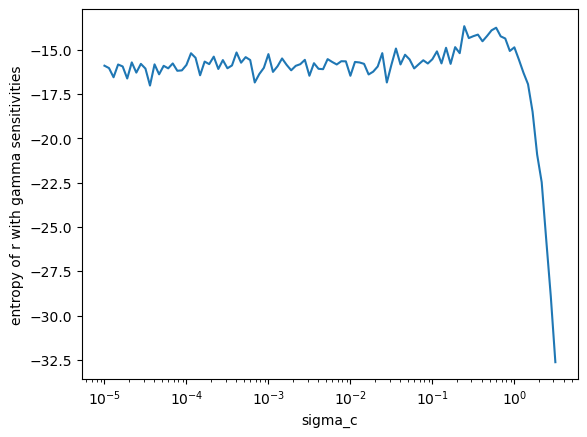

In [36]:
fig, ax = probe_entropy_sigma_relationship(key, jnp.logspace(-5, .5, 100))
fig.savefig('tmp.png') 